# UKPN Constraint Geolocation Analysis

This notebook analyzes UKPN constraint descriptions and maps them to geographic locations using:
- Grid and primary sites CSV (for substations)
- Embedded Capacity Register (ECR) CSV (for generation sites)

The goal is to create a comprehensive geolocation dataset for all constraints.


In [1]:
# Imports and setup
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from difflib import get_close_matches

# Set up paths
WORKDIR = "/Users/aron/project-overflow"
RT_CONSTRAINTS_PATH = os.path.join(WORKDIR, "ukpn-constraints-real-time-meter-readings.csv")
GRID_SITES_PATH = os.path.join(WORKDIR, "grid-and-primary-sites.csv")
ECR_PATH = os.path.join(WORKDIR, "ukpn-embedded-capacity-register.csv")
OUTPUT_DIR = os.path.join(WORKDIR, "outputs")

# Create outputs directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify files exist
for path in [RT_CONSTRAINTS_PATH, GRID_SITES_PATH, ECR_PATH]:
    assert os.path.exists(path), f"Missing file: {path}"

print("Setup complete. Ready to analyze constraint geolocation.")


Setup complete. Ready to analyze constraint geolocation.


In [2]:
# Load the datasets
print("=" * 60)
print("LOADING DATASETS")
print("=" * 60)

# Load constraints data
constraints_df = pd.read_csv(RT_CONSTRAINTS_PATH)
unique_descriptions = constraints_df['constraint_description'].unique()
print(f"Loaded {len(constraints_df)} constraint readings with {len(unique_descriptions)} unique descriptions")

# Load grid and primary sites
grid_sites_df = pd.read_csv(GRID_SITES_PATH)
print(f"Loaded {len(grid_sites_df)} grid and primary sites")
print(f"Grid sites columns: {list(grid_sites_df.columns)[:10]}...")  # Show first 10 columns

# Load ECR (generation sites)
ecr_df = pd.read_csv(ECR_PATH)
print(f"Loaded {len(ecr_df)} ECR generation sites")
print(f"ECR columns: {list(ecr_df.columns)[:10]}...")  # Show first 10 columns

# Check coordinate fields
print("\nCoordinate fields in grid sites:")
coord_cols_grid = [col for col in grid_sites_df.columns if any(x in col.lower() for x in ['easting', 'northing', 'lat', 'lon', 'coordinate'])]
print(coord_cols_grid)

print("\nCoordinate fields in ECR:")
coord_cols_ecr = [col for col in ecr_df.columns if any(x in col.lower() for x in ['easting', 'northing', 'lat', 'lon', 'coordinate'])]
print(coord_cols_ecr)


LOADING DATASETS
Loaded 159 constraint readings with 159 unique descriptions
Loaded 1500 grid and primary sites
Grid sites columns: ['SiteFunctionalLocation', 'LicenceArea', 'SiteName', 'SiteType', 'SiteVoltage', 'ESQCROverallRisk', 'GridRef', 'SiteAssetCount', 'PowerTransformerCount', 'ElectricalAssetCount']...
Loaded 1240 ECR generation sites
ECR columns: ['Export MPAN / MSID', 'Import MPAN / MSID', 'Customer Name', 'Customer Site', 'Address Line 1', 'Address Line 2', 'Town/ City', 'County', 'Postcode', 'Country']...

Coordinate fields in grid sites:
['CalculatedResistance', 'Easting', 'Northing', 'Spatial Coordinates']

Coordinate fields in ECR:
['Location (X-coordinate):_Eastings (where data is held)', 'Location (y-coordinate):_Northings (where data is held)', 'Longitude', 'Latitude', 'SpatialCoordinates_Customer']


In [3]:
# Categorize constraint types
print("=" * 60)
print("CATEGORIZING CONSTRAINT TYPES")
print("=" * 60)

def categorize_constraint(description):
    """Categorize constraint description into types"""
    desc = description.upper()
    
    # Type 4: Solar farm connections
    if 'SOLAR FARM' in desc or 'SOLAR FM' in desc:
        return 'solar_farm'
    
    # Type 3: Aggregate/Sum constraints
    if 'SUM' in desc or ' - SUM' in desc:
        return 'aggregate'
    
    # Type 2: Transmission circuits (has 'tee' indicating between locations)
    if ' TEE ' in desc:
        return 'transmission_circuit'
    
    # Type 5A: Power stations
    if 'PWR STN' in desc or 'POWERSTN' in desc or 'POWER STN' in desc:
        return 'power_station'
    
    # Type 5B-D: Individual transformers
    if any(x in desc for x in [' GT1', ' GT2', ' GT3', ' GT4', ' SGT1', ' SGT2', ' SGT3', ' SGT4', ' T1', ' T2', ' T3', ' T4']):
        return 'transformer'
    
    # Type 5C: Overhead lines
    if 'OHL BETWEEN' in desc:
        return 'overhead_line'
    
    # Type 1: Grid/Primary substations (default)
    return 'substation'

# Create constraints analysis DataFrame
constraints_analysis = pd.DataFrame({
    'constraint_description': unique_descriptions
})

constraints_analysis['constraint_type'] = constraints_analysis['constraint_description'].apply(categorize_constraint)

# Show categorization results
type_counts = constraints_analysis['constraint_type'].value_counts()
print("Constraint categorization:")
for constraint_type, count in type_counts.items():
    print(f"  {constraint_type}: {count} constraints")

print("\nExamples by type:")
for constraint_type in type_counts.index:
    examples = constraints_analysis[constraints_analysis['constraint_type'] == constraint_type]['constraint_description'].head(3).tolist()
    print(f"\n{constraint_type.upper()}:")
    for i, example in enumerate(examples):
        print(f"  {i+1}. {example}")


CATEGORIZING CONSTRAINT TYPES
Constraint categorization:
  transformer: 50 constraints
  aggregate: 42 constraints
  substation: 34 constraints
  transmission_circuit: 26 constraints
  solar_farm: 6 constraints
  power_station: 1 constraints

Examples by type:

TRANSFORMER:
  1. BURWELL MAIN GRID 132kV - SGT2
  2. Thetford Grid 132/33kV - GT4
  3. Clacton Grid 132/33kV GT1

AGGREGATE:
  1. Lawford 132kV - SUM PYA Route
  2. Eye Primary 33kV - Diss Grid/ Cotton 1 - SUM
  3. Stowmarket Grid 132/33kV - SUM

SUBSTATION:
  1. Lawford 132kV -  CLACTON GRID 2 (PYA  No.2)
  2. Lawford 132kV - BRAMFORD GRID 4 (PJ)
  3. ARBURY GRID 132/33kV - Milton 2 (PMK2)

TRANSMISSION_CIRCUIT:
  1. Bramford 132kV  - BURY GRID tee STOWMARKET GRID 2 (EEPK  No. 2)
  2. Bramford 132kV - BURY GRID tee STOWMARKET GRID 1 (EEPK  No. 1)
  3. Lawford 132kV -  BRAMFORD GRID tee IPSWICH GRID 1 (PEC  No.1)

SOLAR_FARM:
  1. Thorpe Grid 33kV - Stonehouse Solar Fm
  2. Sall Grid 132/33kV - Oulton Airfield Solar Farm
  3. S

In [4]:
# Prepare geolocation datasets
print("=" * 60)
print("PREPARING GEOLOCATION DATASETS")
print("=" * 60)

# Clean and prepare grid sites data
grid_sites_clean = grid_sites_df.copy()
grid_sites_clean['site_name_clean'] = grid_sites_clean['SiteName'].str.upper().str.strip()

# Extract coordinates - check if we have lat/lon or need to convert from easting/northing
if 'Spatial Coordinates' in grid_sites_clean.columns:
    # Parse the "lat, lon" format
    coords = grid_sites_clean['Spatial Coordinates'].str.split(', ', expand=True)
    grid_sites_clean['latitude'] = pd.to_numeric(coords[0], errors='coerce')
    grid_sites_clean['longitude'] = pd.to_numeric(coords[1], errors='coerce')
else:
    # Use individual lat/lon columns if available
    if 'Latitude' in grid_sites_clean.columns:
        grid_sites_clean['latitude'] = pd.to_numeric(grid_sites_clean['Latitude'], errors='coerce')
    if 'Longitude' in grid_sites_clean.columns:
        grid_sites_clean['longitude'] = pd.to_numeric(grid_sites_clean['Longitude'], errors='coerce')

# Clean and prepare ECR data for solar farms
ecr_clean = ecr_df.copy()
ecr_clean['site_name_clean'] = (ecr_clean['Customer Name'].astype(str) + ' ' + ecr_clean['Customer Site'].astype(str)).str.upper().str.strip()
ecr_clean['latitude'] = pd.to_numeric(ecr_clean['Latitude'], errors='coerce')
ecr_clean['longitude'] = pd.to_numeric(ecr_clean['Longitude'], errors='coerce')

print(f"Grid sites with coordinates: {grid_sites_clean.dropna(subset=['latitude', 'longitude']).shape[0]}")
print(f"ECR sites with coordinates: {ecr_clean.dropna(subset=['latitude', 'longitude']).shape[0]}")

# Show sample grid sites
print("\nSample grid site names:")
print(grid_sites_clean[['SiteName', 'site_name_clean', 'SiteType']].head(10))

# Show sample ECR sites
print("\nSample ECR site names:")
print(ecr_clean[['Customer Name', 'Customer Site', 'site_name_clean']].head(10))


PREPARING GEOLOCATION DATASETS
Grid sites with coordinates: 1500
ECR sites with coordinates: 1237

Sample grid site names:
                  SiteName          site_name_clean         SiteType
0    FELIXSTOWE GRID 132KV    FELIXSTOWE GRID 132KV  Grid Substation
1   ERNEST NUNN ROAD 132KV   ERNEST NUNN ROAD 132KV  Grid Substation
2       THAXTED GRID 132kV       THAXTED GRID 132KV  Grid Substation
3       NORWICH MAIN 132kV       NORWICH MAIN 132KV  Grid Substation
4         WEST MARCH 132kV         WEST MARCH 132KV  Grid Substation
5  WEST RAYNHAM FARM 132kV  WEST RAYNHAM FARM 132KV  Grid Substation
6  PALM PAPER INTAKE 132kV  PALM PAPER INTAKE 132KV  Grid Substation
7     TOTTENHAM GRID 132kV     TOTTENHAM GRID 132KV  Grid Substation
8        PELHAM GRID 132kV        PELHAM GRID 132KV  Grid Substation
9          TOTTENHAM 132kV          TOTTENHAM 132KV  Grid Substation

Sample ECR site names:
                     Customer Name          Customer Site  \
0             A I A MANAGEMENT LT

In [5]:
# Helper functions for geolocation matching
def extract_main_location(description, constraint_type):
    """Extract the main location name from constraint description"""
    desc = description.upper()
    
    if constraint_type == 'transmission_circuit':
        # Extract both 'from' and 'to' locations for circuits
        # Example: "Bramford 132kV - BURY GRID tee STOWMARKET GRID 1"
        parts = desc.split(' TEE ')
        if len(parts) >= 2:
            from_part = parts[0].split(' - ')[-1].strip()  # Get part after last ' - '
            to_part = parts[1].split('(')[0].strip()       # Get part before '('
            return from_part, to_part
        return None, None
    
    elif constraint_type == 'solar_farm':
        # Extract solar farm name
        # Example: "Spixworth Road Solar Farm - Sall Grid 2"
        if 'SOLAR FARM' in desc:
            return desc.split('SOLAR FARM')[0].strip() + ' SOLAR FARM'
        elif 'SOLAR FM' in desc:
            return desc.split('SOLAR FM')[0].strip() + ' SOLAR FM'
    
    else:
        # Extract main substation/site name
        # Examples: "ARBURY GRID 132/33kV - GT1" -> "ARBURY GRID"
        #           "Bramford 132kV - SUM EEPK route" -> "BRAMFORD"
        
        # Remove common suffixes and get the base name
        for suffix in [' 132KV', ' 132/33KV', ' 33KV', ' 11KV', ' GRID', ' PRIMARY']:
            if suffix in desc:
                base = desc.split(suffix)[0].strip()
                if base:
                    return base + (' GRID' if 'GRID' in desc else '')
        
        # Fallback: take everything before first ' - '
        if ' - ' in desc:
            return desc.split(' - ')[0].strip()
        
        return desc.strip()

def find_best_match(target_name, candidate_names, threshold=0.6):
    """Find best matching site name using fuzzy matching"""
    if not target_name:
        return None
    
    # Try exact match first
    if target_name in candidate_names:
        return target_name
    
    # Try fuzzy matching
    matches = get_close_matches(target_name, candidate_names, n=1, cutoff=threshold)
    return matches[0] if matches else None

print("Geolocation helper functions defined.")


Geolocation helper functions defined.


In [6]:
# Apply geolocation to constraints
print("=" * 60)
print("APPLYING GEOLOCATION TO CONSTRAINTS")
print("=" * 60)

# Initialize result columns
constraints_analysis['main_location'] = None
constraints_analysis['secondary_location'] = None
constraints_analysis['matched_site'] = None
constraints_analysis['latitude'] = None
constraints_analysis['longitude'] = None
constraints_analysis['latitude_2'] = None
constraints_analysis['longitude_2'] = None
constraints_analysis['geolocation_source'] = None
constraints_analysis['geolocation_method'] = None

# Get candidate site names
grid_candidate_names = grid_sites_clean['site_name_clean'].dropna().tolist()
ecr_candidate_names = ecr_clean['site_name_clean'].dropna().tolist()

# Process each constraint
for idx, row in constraints_analysis.iterrows():
    desc = row['constraint_description']
    constraint_type = row['constraint_type']
    
    if constraint_type == 'transmission_circuit':
        # Handle transmission circuits (Type 2)
        from_loc, to_loc = extract_main_location(desc, constraint_type)
        constraints_analysis.at[idx, 'main_location'] = from_loc
        constraints_analysis.at[idx, 'secondary_location'] = to_loc
        
        # Try to match both locations to grid sites
        if from_loc:
            match1 = find_best_match(from_loc, grid_candidate_names)
            if match1:
                matched_row = grid_sites_clean[grid_sites_clean['site_name_clean'] == match1].iloc[0]
                constraints_analysis.at[idx, 'latitude'] = matched_row['latitude']
                constraints_analysis.at[idx, 'longitude'] = matched_row['longitude']
                constraints_analysis.at[idx, 'geolocation_source'] = 'grid_sites'
        
        if to_loc:
            match2 = find_best_match(to_loc, grid_candidate_names)
            if match2:
                matched_row = grid_sites_clean[grid_sites_clean['site_name_clean'] == match2].iloc[0]
                constraints_analysis.at[idx, 'latitude_2'] = matched_row['latitude']
                constraints_analysis.at[idx, 'longitude_2'] = matched_row['longitude']
                constraints_analysis.at[idx, 'geolocation_method'] = 'transmission_line'
    
    elif constraint_type == 'solar_farm':
        # Handle solar farms (Type 4)
        solar_name = extract_main_location(desc, constraint_type)
        constraints_analysis.at[idx, 'main_location'] = solar_name
        
        if solar_name:
            # Try to match to ECR first
            match = find_best_match(solar_name, ecr_candidate_names, threshold=0.5)
            if match:
                matched_row = ecr_clean[ecr_clean['site_name_clean'] == match].iloc[0]
                constraints_analysis.at[idx, 'matched_site'] = match
                constraints_analysis.at[idx, 'latitude'] = matched_row['latitude']
                constraints_analysis.at[idx, 'longitude'] = matched_row['longitude']
                constraints_analysis.at[idx, 'geolocation_source'] = 'ecr'
                constraints_analysis.at[idx, 'geolocation_method'] = 'solar_farm_direct'
    
    else:
        # Handle substations, transformers, aggregates (Types 1, 3, 5)
        main_loc = extract_main_location(desc, constraint_type)
        constraints_analysis.at[idx, 'main_location'] = main_loc
        
        if main_loc:
            # Try to match to grid sites
            match = find_best_match(main_loc, grid_candidate_names)
            if match:
                matched_row = grid_sites_clean[grid_sites_clean['site_name_clean'] == match].iloc[0]
                constraints_analysis.at[idx, 'matched_site'] = match
                constraints_analysis.at[idx, 'latitude'] = matched_row['latitude']
                constraints_analysis.at[idx, 'longitude'] = matched_row['longitude']
                constraints_analysis.at[idx, 'geolocation_source'] = 'grid_sites'
                constraints_analysis.at[idx, 'geolocation_method'] = 'substation_direct'

# Calculate success rates
total_constraints = len(constraints_analysis)
geolocated = constraints_analysis.dropna(subset=['latitude', 'longitude'])
success_rate = len(geolocated) / total_constraints * 100

print(f"Geolocation Results:")
print(f"Total constraints: {total_constraints}")
print(f"Successfully geolocated: {len(geolocated)} ({success_rate:.1f}%)")

# Show results by type
print("\nSuccess rate by constraint type:")
for constraint_type in constraints_analysis['constraint_type'].unique():
    type_df = constraints_analysis[constraints_analysis['constraint_type'] == constraint_type]
    type_geolocated = type_df.dropna(subset=['latitude', 'longitude'])
    type_rate = len(type_geolocated) / len(type_df) * 100 if len(type_df) > 0 else 0
    print(f"  {constraint_type}: {len(type_geolocated)}/{len(type_df)} ({type_rate:.1f}%)")


APPLYING GEOLOCATION TO CONSTRAINTS
Geolocation Results:
Total constraints: 159
Successfully geolocated: 148 (93.1%)

Success rate by constraint type:
  transmission_circuit: 22/26 (84.6%)
  substation: 30/34 (88.2%)
  aggregate: 40/42 (95.2%)
  transformer: 50/50 (100.0%)
  power_station: 0/1 (0.0%)
  solar_farm: 6/6 (100.0%)


In [7]:
# Handle transmission circuits - calculate midpoints
print("=" * 60)
print("PROCESSING TRANSMISSION CIRCUITS")
print("=" * 60)

# For transmission circuits with both endpoints, calculate midpoint
transmission_circuits = constraints_analysis[constraints_analysis['constraint_type'] == 'transmission_circuit'].copy()
both_endpoints = transmission_circuits.dropna(subset=['latitude', 'longitude', 'latitude_2', 'longitude_2'])

if len(both_endpoints) > 0:
    print(f"Found {len(both_endpoints)} transmission circuits with both endpoints located.")
    
    # Calculate midpoints
    midpoint_lat = (both_endpoints['latitude'] + both_endpoints['latitude_2']) / 2
    midpoint_lon = (both_endpoints['longitude'] + both_endpoints['longitude_2']) / 2
    
    # Update the main coordinates to midpoint for transmission circuits
    constraints_analysis.loc[both_endpoints.index, 'latitude'] = midpoint_lat
    constraints_analysis.loc[both_endpoints.index, 'longitude'] = midpoint_lon
    constraints_analysis.loc[both_endpoints.index, 'geolocation_method'] = 'transmission_midpoint'
    
    print("Updated transmission circuit coordinates to midpoints.")
    
    # Show some examples
    print("\nExamples of transmission circuits:")
    for idx, row in both_endpoints.head(3).iterrows():
        print(f"  {row['constraint_description']}")
        print(f"    From: {row['main_location']} -> To: {row['secondary_location']}")
        print(f"    Midpoint: ({constraints_analysis.loc[idx, 'latitude']:.4f}, {constraints_analysis.loc[idx, 'longitude']:.4f})")
        print()

# Recalculate success rate
geolocated_final = constraints_analysis.dropna(subset=['latitude', 'longitude'])
final_success_rate = len(geolocated_final) / total_constraints * 100

print(f"\nFinal geolocation success rate: {len(geolocated_final)}/{total_constraints} ({final_success_rate:.1f}%)")


PROCESSING TRANSMISSION CIRCUITS
Found 21 transmission circuits with both endpoints located.
Updated transmission circuit coordinates to midpoints.

Examples of transmission circuits:
  Bramford 132kV  - BURY GRID tee STOWMARKET GRID 2 (EEPK  No. 2)
    From: BURY GRID -> To: STOWMARKET GRID 2
    Midpoint: (51.6695, 0.6807)

  Bramford 132kV - BURY GRID tee STOWMARKET GRID 1 (EEPK  No. 1)
    From: BURY GRID -> To: STOWMARKET GRID 1
    Midpoint: (51.6695, 0.6807)

  Lawford 132kV -  BRAMFORD GRID tee IPSWICH GRID 1 (PEC  No.1)
    From: BRAMFORD GRID -> To: IPSWICH GRID 1
    Midpoint: (52.0630, 1.0994)


Final geolocation success rate: 148/159 (93.1%)


In [8]:
# Save results
print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save the complete constraint geolocation analysis
output_file = os.path.join(OUTPUT_DIR, 'constraint_geolocation_analysis.csv')
constraints_analysis.to_csv(output_file, index=False)
print(f"Complete analysis saved to: {output_file}")

# Save only successfully geolocated constraints
geolocated_file = os.path.join(OUTPUT_DIR, 'constraints_geolocated.csv')
geolocated_final.to_csv(geolocated_file, index=False)
print(f"Geolocated constraints saved to: {geolocated_file}")

# Save unmatched for manual review
unmatched = constraints_analysis[constraints_analysis['latitude'].isna()]
if len(unmatched) > 0:
    unmatched_file = os.path.join(OUTPUT_DIR, 'constraints_unmatched.csv')
    unmatched.to_csv(unmatched_file, index=False)
    print(f"Unmatched constraints saved to: {unmatched_file}")

# Create summary statistics
summary_stats = {
    'total_constraints': total_constraints,
    'geolocated_constraints': len(geolocated_final),
    'success_rate_percent': final_success_rate,
    'by_type': {}
}

for constraint_type in constraints_analysis['constraint_type'].unique():
    type_df = constraints_analysis[constraints_analysis['constraint_type'] == constraint_type]
    type_geolocated = type_df.dropna(subset=['latitude', 'longitude'])
    summary_stats['by_type'][constraint_type] = {
        'total': len(type_df),
        'geolocated': len(type_geolocated),
        'success_rate': len(type_geolocated) / len(type_df) * 100 if len(type_df) > 0 else 0
    }

print("\nSUMMARY STATISTICS:")
print(f"Total constraints: {summary_stats['total_constraints']}")
print(f"Successfully geolocated: {summary_stats['geolocated_constraints']} ({summary_stats['success_rate_percent']:.1f}%)")
print("\nBy constraint type:")
for constraint_type, stats in summary_stats['by_type'].items():
    print(f"  {constraint_type}: {stats['geolocated']}/{stats['total']} ({stats['success_rate']:.1f}%)")


SAVING RESULTS
Complete analysis saved to: /Users/aron/project-overflow/outputs/constraint_geolocation_analysis.csv
Geolocated constraints saved to: /Users/aron/project-overflow/outputs/constraints_geolocated.csv
Unmatched constraints saved to: /Users/aron/project-overflow/outputs/constraints_unmatched.csv

SUMMARY STATISTICS:
Total constraints: 159
Successfully geolocated: 148 (93.1%)

By constraint type:
  transmission_circuit: 22/26 (84.6%)
  substation: 30/34 (88.2%)
  aggregate: 40/42 (95.2%)
  transformer: 50/50 (100.0%)
  power_station: 0/1 (0.0%)
  solar_farm: 6/6 (100.0%)


CREATING VISUALIZATION


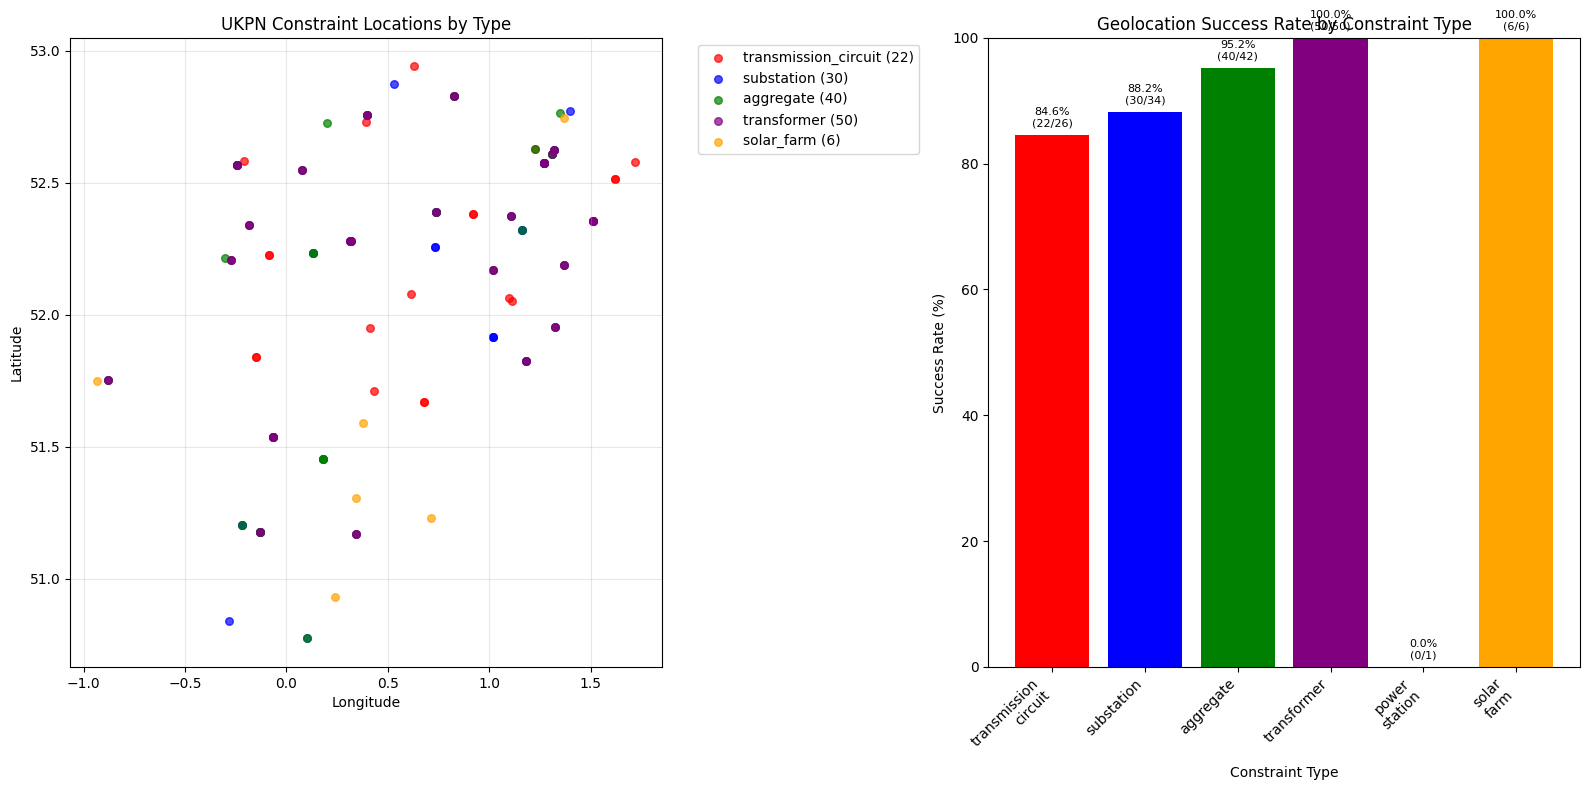

Visualization saved to: /Users/aron/project-overflow/outputs/constraint_geolocation_analysis.png

CONSTRAINT GEOLOCATION ANALYSIS COMPLETE
Successfully geolocated 148 out of 159 constraints (93.1%)
This provides spatial coordinates for constraint breach analysis and heatmap generation.


In [9]:
# Create visualization of geolocated constraints
print("=" * 60)
print("CREATING VISUALIZATION")
print("=" * 60)

# Create a map showing constraint locations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: All geolocated constraints
colors = {'substation': 'blue', 'transmission_circuit': 'red', 'aggregate': 'green', 
          'solar_farm': 'orange', 'transformer': 'purple', 'power_station': 'brown', 
          'overhead_line': 'pink'}

for constraint_type in geolocated_final['constraint_type'].unique():
    type_data = geolocated_final[geolocated_final['constraint_type'] == constraint_type]
    ax1.scatter(type_data['longitude'], type_data['latitude'], 
               c=colors.get(constraint_type, 'gray'), 
               label=f'{constraint_type} ({len(type_data)})',
               alpha=0.7, s=30)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('UKPN Constraint Locations by Type')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Success rate by type
types = list(summary_stats['by_type'].keys())
success_rates = [summary_stats['by_type'][t]['success_rate'] for t in types]
totals = [summary_stats['by_type'][t]['total'] for t in types]

bars = ax2.bar(range(len(types)), success_rates, color=[colors.get(t, 'gray') for t in types])
ax2.set_xlabel('Constraint Type')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Geolocation Success Rate by Constraint Type')
ax2.set_xticks(range(len(types)))
ax2.set_xticklabels([t.replace('_', '\n') for t in types], rotation=45, ha='right')
ax2.set_ylim(0, 100)

# Add value labels on bars
for i, (bar, rate, total) in enumerate(zip(bars, success_rates, totals)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rate:.1f}%\n({summary_stats["by_type"][types[i]]["geolocated"]}/{total})',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
chart_file = os.path.join(OUTPUT_DIR, 'constraint_geolocation_analysis.png')
plt.savefig(chart_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"Visualization saved to: {chart_file}")

print("\n" + "=" * 60)
print("CONSTRAINT GEOLOCATION ANALYSIS COMPLETE")
print("=" * 60)
print(f"Successfully geolocated {len(geolocated_final)} out of {total_constraints} constraints ({final_success_rate:.1f}%)")
print(f"This provides spatial coordinates for constraint breach analysis and heatmap generation.")
